# Gradual subsamples with TPOT
TPOT takes a lot of time to evaluate machine learning pipelines.
A pipeline could be faster evaluated on only a subset of the data.
The downside of this is that the resulting score of the pipeline might not reflect the true score it would get by using all available data.
There is an idea to balance the two out: evaluate new pipelines on a subset of the data, and if it proves to perform well and is taken to a next generation, increase the subset of data the pipeline will be tested on.


This approach is implemented in TPOT branch [name-and-link-here].
In implementation aspect, the changes are as follows:
* the TPOT constructor is provided with a desired `gradual_factor` (float in range (0,1]).
* each individual is evaluated only on `gradual_factor` portion of the data initially, whenever it survives a generation, the next generation it will be evaluated on `gradual_factor` more, with a maximum of using all the data (i.e. `gradual_factor` is 0.35, then the individual will be tested on 0.35, 0.7 and 1.0 in successive generations.).

This means more work is done for those individuals who survive generations, but for all other individuals less work is done.
Because there should be relatively few individuals carried over to the next generation without and mutation or cross-over, this should result in an overall faster TPOT.
Original functionality is preserved if `gradual_factor` is 1.0.

The data of this experiment is obtained by calling `gradual_tpot_test.py`.
Internally, it calls script [`Gradual_TPOT.py`](Gradual_TPOT.py), which when called can do a TPOT experiment with given parameters.

**current results for 11 datasets of PMLB only**

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

results = pd.read_csv('results/gradual_tpot_2.csv', index_col=None, sep=';', comment='#')
results.head()

,dataset,repeat,gradualfactor,time,score,seed
0,analcatdata_asbestos,0,1.0,14.836318,0.750000,44
1,analcatdata_asbestos,1,1.0,14.735266,0.750000,44
2,analcatdata_asbestos,0,1.0,16.195076,0.694444,45
3,analcatdata_asbestos,1,1.0,15.601079,0.694444,45
4,analcatdata_asbestos,0,1.0,12.382623,0.791667,46


# Quantifying the speed-up
The first task will be to evaluate if there actually was a speed-up, so we plot the difference in time in seconds per dataset.
To make comparing easier, slow downs are shown in red, and speed ups are down in blue.

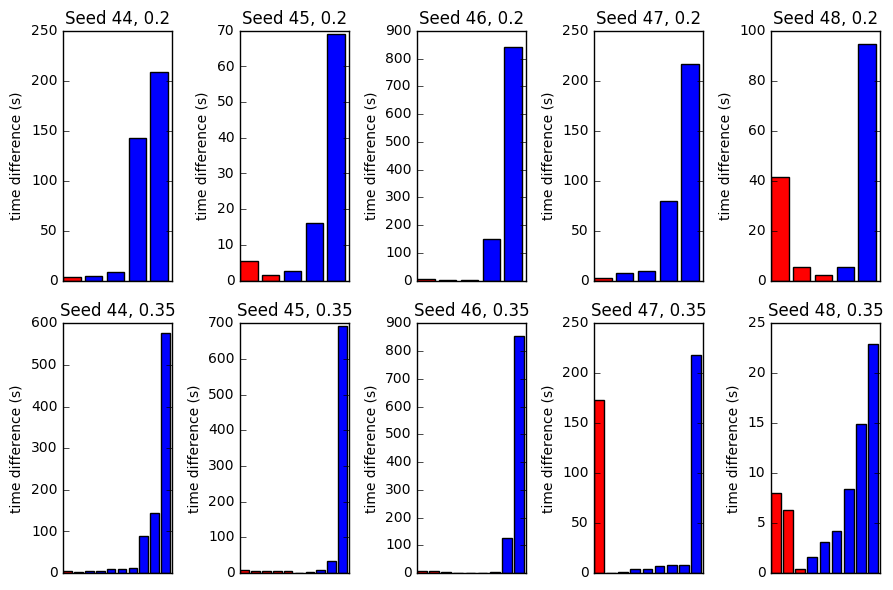

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(9,6))
h = results.groupby(by=['seed','gradualfactor', 'dataset']).mean()
seeds = [44,45,46,47,48]
sub_sizes = [0.2, 0.35]

for i, seed in enumerate(seeds):
    for j, subsize in enumerate(sub_sizes):
        time_difference = (h.loc[(seed,1.0)].time - h.loc[(seed,subsize)].time).sort_values().reset_index().time
        speed_up = time_difference[time_difference >= 0]
        # It is easier to compare sizes of bars if they both steer on the same side of the x-axis,
        # so we make slowdowns a positive number, but will plot them in red.
        speed_down = -1 * time_difference[time_difference < 0]
        axes[j,i].bar(speed_down.index, speed_down, color='r')
        axes[j,i].bar(speed_up.index, speed_up)
        axes[j,i].set_title('Seed {}, {}'.format(seed, subsize))
        axes[j,i].set_ylabel('time difference (s)')
        axes[j,i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off') 
fig.tight_layout() 

First off, it should be clear that there are more datasets evaluated with `gradual_factor=0.35` than `0.2`.
This is because currently mostly only small datasets are used, and they are too small to be divided first in train and test split, then into a subsample of the data, and then again for k-fold validation whenever the `gradual_factor` is too small (for some case, this breakpoint turned out to be between `0.35` and `0.2`.

However, the general picture is clear, there are speed-ups.
To see how big they are relatively, we will also plot them as a ratio of old over new, a bigger number is then a bigger speed-up.

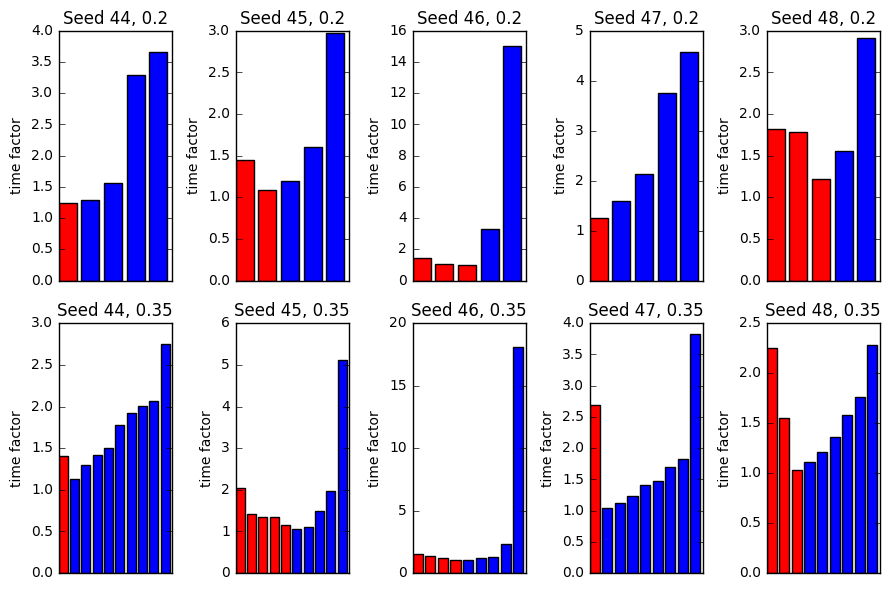

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(9,6))

for i, seed in enumerate(seeds):
    for j, subsize in enumerate(sub_sizes):
        time_difference = (h.loc[(seed,1.0)].time / h.loc[(seed,subsize)].time).sort_values().reset_index().time
        speed_up = time_difference[time_difference >= 1]
        # It is easier to compare sizes of bars if they both steer on the same side of the x-axis,
        # so we make slowdowns a positive number, but will plot them in red.
        speed_down = 1 / time_difference[time_difference < 1]
        axes[j,i].bar(speed_down.index, speed_down, color='r')
        axes[j,i].bar(speed_up.index, speed_up)
        axes[j,i].set_title('Seed {}, {}'.format(seed, subsize))
        axes[j,i].set_ylabel('time factor')
        axes[j,i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off') 
fig.tight_layout() 

This paints a slightly less impressive picture, apparently in some cases slow downs seem to be roughly the same as the speed-ups. Let's see where the big slow-downs come from:

In [9]:
print('Slow down factors for datasets and starting seed 48')
for i, seed in enumerate([48]):
    for j, subsize in enumerate(sub_sizes):
        time_difference = 1 / (h.loc[(seed,1.0)].time / h.loc[(seed,subsize)].time).sort_values()
        print(time_difference.head(3))

Slow down factors for datasets and starting seed 48
dataset
analcatdata_boxing1     1.818686
analcatdata_dmft        1.778409
analcatdata_asbestos    1.223262
Name: time, dtype: float64
dataset
analcatdata_boxing1       2.249490
analcatdata_bankruptcy    1.548038
analcatdata_boxing2       1.030456
Name: time, dtype: float64


Both 'analcatdat_boxing1' and 'analcatdata_bankruptcy' are very small datasets, of sizes (120,3) and (50,6) respectively.
It could be that here the additional splitting of the data, and looking up on which subsize to evaluate the data causes more overhead than it helps.
While 'analcatdata_dmft' is slightly bigger with a size of (797,4), and is less likely to see significant impact by overhead.

However, one should keep in mind that while the random state guarantees that the initial generation will be generated the same, subsequent generations need not.
Because pipelines are evaluated on a different sample of the data, their scores might differ as well, giving rise to different subsequent generations.
Given enough expriments, one might expect there to be some slow-downs in the case that an approach with a gradual factor gets stuck on an inherently slow pipeline, which might have been avoided by dumb luck for the full evaluation.

Finally, we look at the speed difference across all seeds - the average speed up:

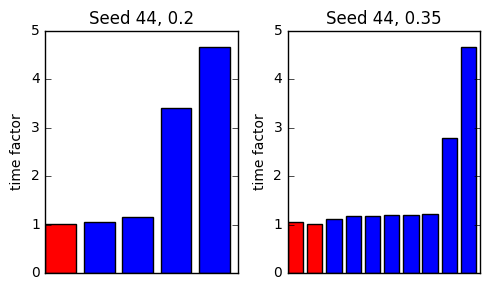

In [36]:
overall = results.groupby(by=['gradualfactor', 'dataset']).mean()

    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5,3))

for j, subsize in enumerate(sub_sizes):
    time_difference = (overall.loc[1.0].time / overall.loc[subsize].time).sort_values().reset_index().time
    speed_up = time_difference[time_difference >= 1]
    # It is easier to compare sizes of bars if they both steer on the same side of the x-axis,
    # so we make slowdowns a positive number, but will plot them in red.
    speed_down = 1 / time_difference[time_difference < 1]
    axes[j].bar(speed_down.index, speed_down, color='r')
    axes[j].bar(speed_up.index, speed_up)
    axes[j].set_title('Seed {}, {}'.format(seed, subsize))
    axes[j].set_ylabel('time factor')
    axes[j].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off') 
fig.tight_layout() 

Most of the time, it will become only slightly faster, though sometimes it will really speed up TPOT.
From a time saving perspective, it seems promising to evaluate Gradual TPOT on more data.

# Comparing Accuracy

In a similar way, we should look at the effect of only using a subsample of the data for accuracy.
First, we look at the differences in accuracy obtained by only training on a subsample of the data:

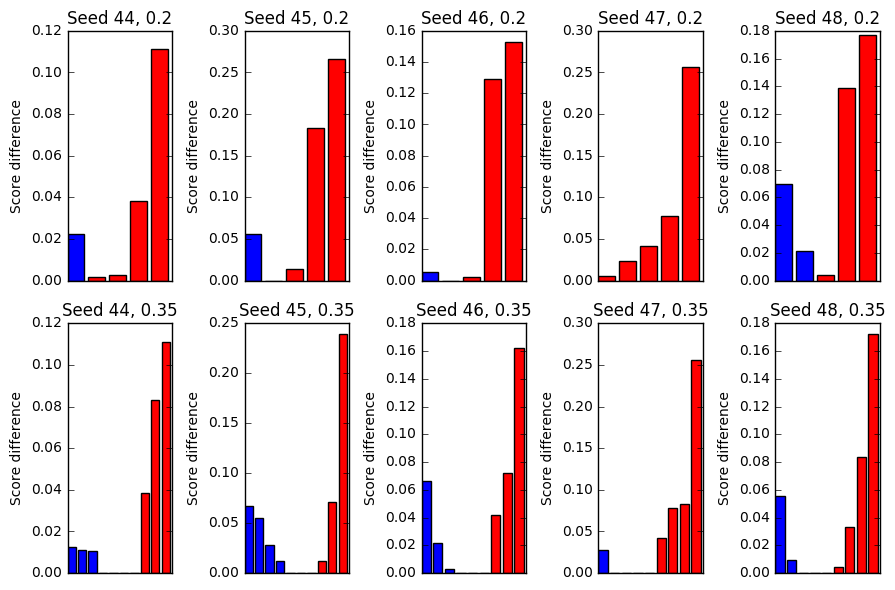

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(9,6))

for i, seed in enumerate(seeds):
    for j, subsize in enumerate(sub_sizes):
        score_diff = (h.loc[(seed,1.0)].score - h.loc[(seed,subsize)].score).sort_values().reset_index().score
        score_decrease = score_diff[score_diff >= 0]
        # It is easier to compare sizes of bars if they both steer on the same side of the x-axis,
        # so we make slowdowns a positive number, but will plot them in red.
        score_increase = -1 * score_diff[score_diff < 0]
        axes[j,i].bar(score_decrease.index, score_decrease, color='r')
        axes[j,i].bar(score_increase.index, score_increase)
        axes[j,i].set_title('Seed {}, {}'.format(seed, subsize))
        axes[j,i].set_ylabel('Score difference')
        axes[j,i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off') 
fig.tight_layout() 

Gradual TPOT loses a lot of accuracy for its generally small increase in speed.
The average gives the same picture:

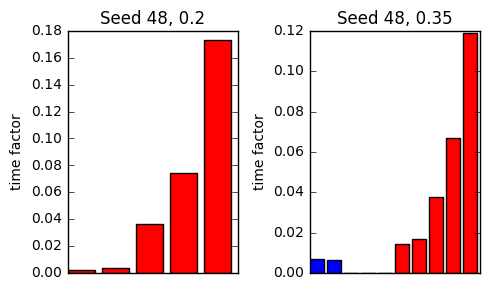

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5,3))

for j, subsize in enumerate(sub_sizes):
    time_difference = (overall.loc[1.0].score - overall.loc[subsize].score).sort_values().reset_index().score
    speed_up = time_difference[time_difference >= 0]
    # It is easier to compare sizes of bars if they both steer on the same side of the x-axis,
    # so we make slowdowns a positive number, but will plot them in red.
    speed_down = -1 * time_difference[time_difference < 0]
    axes[j].bar(speed_down.index, speed_down)
    axes[j].bar(speed_up.index, speed_up, color='r')
    axes[j].set_title('Seed {}, {}'.format(seed, subsize))
    axes[j].set_ylabel('time factor')
    axes[j].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off') 
fig.tight_layout() 

However, I think this could also stem from the fact that the datasets evaluated are pretty small.
Some of the datasets have as little as 100 samples.
When subdividing this dataset even more, one might discard important characteristics of the data.
I think it is interesting to see if for more and bigger datasets, Gradual TPOT is able to generalize well.